# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

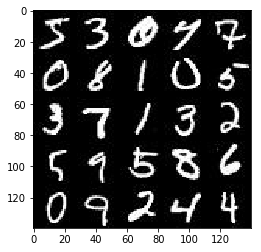

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

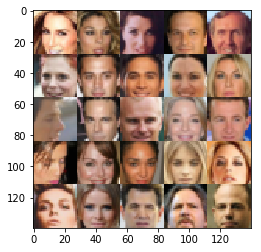

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return input_real,input_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "c:\\users\\jinka\\appdata\\local\\conda\\conda\\envs\\rnn\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "c:\\users\\jinka\\appdata\\local\\conda\\conda\\envs\\rnn\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "c:\\users\\jinka\\appdata\\local\\conda\\conda\\envs\\rnn\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "c:\\users\\jinka\\appdata\\local\\conda\\conda\\envs\\rnn\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "c:\\users\\jinka\\appdata\\local\\conda\\conda\\envs\\rnn\\lib\\site-packages\\ipykernel\\kern

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator',reuse=reuse):
        
        #x1 = tf.layers.dense(images,128,activation=None)
        #x1 = tf.maximum(alpha*x1,x1)
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha*x1,x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2,bn2)    
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        # 4x4x256
        
      
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        out = tf.nn.sigmoid(logits)
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [71]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        #x1 = tf.layers.dropout(x1, 0.5, training=is_train)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())        
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2,x2)
        #x2 = tf.layers.dropout(x2, 0.5, training=is_train)
        # 14x14x64 now
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())        
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3,x3)
        #x3 = tf.layers.dropout(x3, 0.5, training=is_train)
        # 28x28x32 now
     
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        #logits = tf.layers.dropout(logits, 0.5, training=is_train)
        # 28x28xout_channel_dim now        
        out = tf.nn.tanh(logits)
   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [72]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1-smoth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [73]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [74]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [75]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
        # TODO: Train Model
                steps+=1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, lr: learning_rate, input_real: batch_images})
            
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Batch: {:.4f}".format(steps))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.9165 Batch: 10.0000
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 1.3483 Batch: 20.0000
Epoch 1/2... Discriminator Loss: 2.3641... Generator Loss: 4.3869 Batch: 30.0000
Epoch 1/2... Discriminator Loss: 2.0345... Generator Loss: 0.2712 Batch: 40.0000
Epoch 1/2... Discriminator Loss: 2.5614... Generator Loss: 2.4506 Batch: 50.0000
Epoch 1/2... Discriminator Loss: 1.6012... Generator Loss: 0.8781 Batch: 60.0000
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 1.0443 Batch: 70.0000
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 1.9307 Batch: 80.0000
Epoch 1/2... Discriminator Loss: 1.5413... Generator Loss: 0.5035 Batch: 90.0000
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 1.5683 Batch: 100.0000


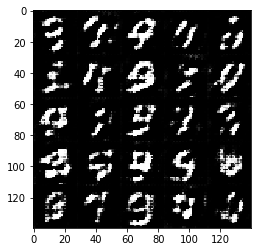

Epoch 1/2... Discriminator Loss: 1.5609... Generator Loss: 0.8532 Batch: 110.0000
Epoch 1/2... Discriminator Loss: 1.5905... Generator Loss: 0.7109 Batch: 120.0000
Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 1.0268 Batch: 130.0000
Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.9798 Batch: 140.0000
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 1.7183 Batch: 150.0000
Epoch 1/2... Discriminator Loss: 1.7823... Generator Loss: 0.3688 Batch: 160.0000
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.8591 Batch: 170.0000
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 1.0271 Batch: 180.0000
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 0.9149 Batch: 190.0000
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 0.5164 Batch: 200.0000


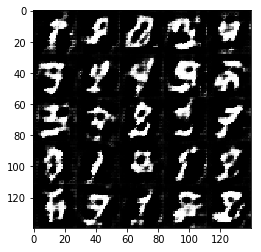

Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 1.1283 Batch: 210.0000
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.7512 Batch: 220.0000
Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 1.7935 Batch: 230.0000
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.6110 Batch: 240.0000
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.6919 Batch: 250.0000
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.9012 Batch: 260.0000
Epoch 1/2... Discriminator Loss: 1.6038... Generator Loss: 0.5072 Batch: 270.0000
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.6965 Batch: 280.0000
Epoch 1/2... Discriminator Loss: 1.4803... Generator Loss: 0.5237 Batch: 290.0000
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 1.2506 Batch: 300.0000


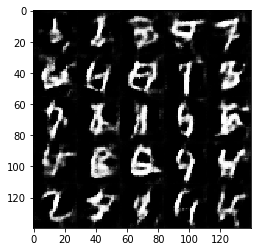

Epoch 1/2... Discriminator Loss: 1.5562... Generator Loss: 0.4792 Batch: 310.0000
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.5794 Batch: 320.0000
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 1.1312 Batch: 330.0000
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.6533 Batch: 340.0000
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 1.0640 Batch: 350.0000
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.5586 Batch: 360.0000
Epoch 1/2... Discriminator Loss: 1.7262... Generator Loss: 1.7255 Batch: 370.0000
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.9234 Batch: 380.0000
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.6696 Batch: 390.0000
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.4482 Batch: 400.0000


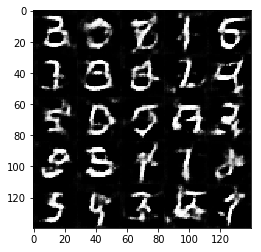

Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.5378 Batch: 410.0000
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 1.2314 Batch: 420.0000
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.7051 Batch: 430.0000
Epoch 1/2... Discriminator Loss: 1.7271... Generator Loss: 0.4415 Batch: 440.0000
Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 0.7402 Batch: 450.0000
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.5172 Batch: 460.0000
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.6047 Batch: 470.0000
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.8922 Batch: 480.0000
Epoch 1/2... Discriminator Loss: 1.4751... Generator Loss: 1.8616 Batch: 490.0000
Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.4474 Batch: 500.0000


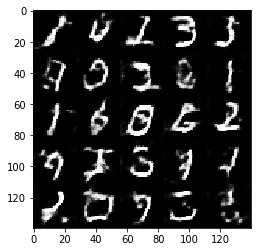

Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.6177 Batch: 510.0000
Epoch 1/2... Discriminator Loss: 1.5510... Generator Loss: 0.4819 Batch: 520.0000
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 1.6716 Batch: 530.0000
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.9259 Batch: 540.0000
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 0.8861 Batch: 550.0000
Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 1.7143 Batch: 560.0000
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.9416 Batch: 570.0000
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.6317 Batch: 580.0000
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 1.2205 Batch: 590.0000
Epoch 1/2... Discriminator Loss: 1.5785... Generator Loss: 0.4443 Batch: 600.0000


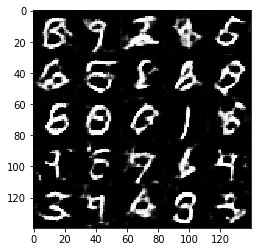

Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.8568 Batch: 610.0000
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.1918 Batch: 620.0000
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.5886 Batch: 630.0000
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 0.8909 Batch: 640.0000
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 1.2018 Batch: 650.0000
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 0.6256 Batch: 660.0000
Epoch 1/2... Discriminator Loss: 1.2887... Generator Loss: 1.1811 Batch: 670.0000
Epoch 1/2... Discriminator Loss: 1.2008... Generator Loss: 0.8030 Batch: 680.0000
Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 1.5881 Batch: 690.0000
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.5088 Batch: 700.0000


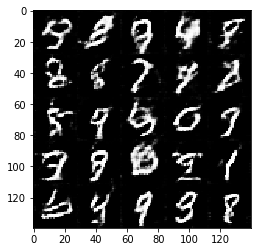

Epoch 1/2... Discriminator Loss: 1.6786... Generator Loss: 0.3670 Batch: 710.0000
Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.5545 Batch: 720.0000
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 1.0772 Batch: 730.0000
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 1.0367 Batch: 740.0000
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 1.0428 Batch: 750.0000
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 1.6280 Batch: 760.0000
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 1.0655 Batch: 770.0000
Epoch 1/2... Discriminator Loss: 1.6840... Generator Loss: 1.4994 Batch: 780.0000
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 1.0795 Batch: 790.0000
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.5843 Batch: 800.0000


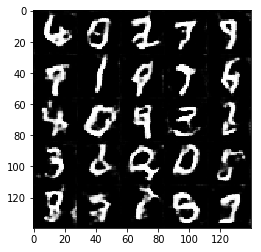

Epoch 1/2... Discriminator Loss: 1.1815... Generator Loss: 1.8042 Batch: 810.0000
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 1.3473 Batch: 820.0000
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.4815 Batch: 830.0000
Epoch 1/2... Discriminator Loss: 1.7986... Generator Loss: 2.8633 Batch: 840.0000
Epoch 1/2... Discriminator Loss: 1.5088... Generator Loss: 0.4619 Batch: 850.0000
Epoch 1/2... Discriminator Loss: 1.4288... Generator Loss: 0.5389 Batch: 860.0000
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 2.2448 Batch: 870.0000
Epoch 1/2... Discriminator Loss: 1.6195... Generator Loss: 0.3649 Batch: 880.0000
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 0.4574 Batch: 890.0000
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 0.8467 Batch: 900.0000


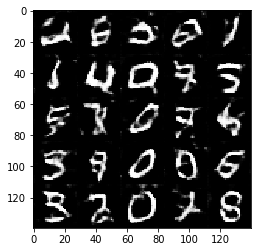

Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.7914 Batch: 910.0000
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.5031 Batch: 920.0000
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.6368 Batch: 930.0000
Epoch 1/2... Discriminator Loss: 1.5206... Generator Loss: 0.5336 Batch: 940.0000
Epoch 1/2... Discriminator Loss: 0.9223... Generator Loss: 1.2403 Batch: 950.0000
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 1.2740 Batch: 960.0000
Epoch 1/2... Discriminator Loss: 2.0422... Generator Loss: 0.4049 Batch: 970.0000
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 1.3027 Batch: 980.0000
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.6187 Batch: 990.0000
Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 0.6100 Batch: 1000.0000


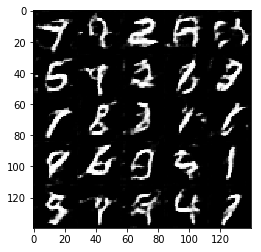

Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 0.7877 Batch: 1010.0000
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.5688 Batch: 1020.0000
Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 0.4715 Batch: 1030.0000
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 1.3472 Batch: 1040.0000
Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 0.7648 Batch: 1050.0000
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 1.4860 Batch: 1060.0000
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 0.7242 Batch: 1070.0000
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 1.0194 Batch: 1080.0000
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.6393 Batch: 1090.0000
Epoch 1/2... Discriminator Loss: 1.5519... Generator Loss: 0.4649 Batch: 1100.0000


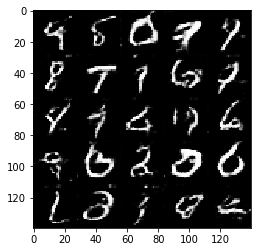

Epoch 1/2... Discriminator Loss: 1.7021... Generator Loss: 0.3757 Batch: 1110.0000
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 1.0419 Batch: 1120.0000
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 1.0326 Batch: 1130.0000
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 0.6436 Batch: 1140.0000
Epoch 1/2... Discriminator Loss: 1.0726... Generator Loss: 1.1252 Batch: 1150.0000
Epoch 1/2... Discriminator Loss: 0.8226... Generator Loss: 1.6400 Batch: 1160.0000
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 1.6800 Batch: 1170.0000
Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.2403 Batch: 1180.0000
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 1.8084 Batch: 1190.0000
Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 2.4577 Batch: 1200.0000


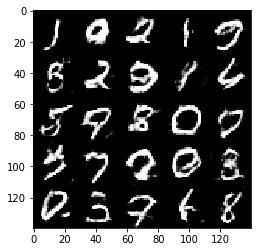

Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.1013 Batch: 1210.0000
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 0.8938 Batch: 1220.0000
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.6423 Batch: 1230.0000
Epoch 1/2... Discriminator Loss: 1.0368... Generator Loss: 0.8033 Batch: 1240.0000
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 1.2104 Batch: 1250.0000
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.9778 Batch: 1260.0000
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 1.0594 Batch: 1270.0000
Epoch 1/2... Discriminator Loss: 0.8043... Generator Loss: 1.3862 Batch: 1280.0000
Epoch 1/2... Discriminator Loss: 1.7439... Generator Loss: 0.3859 Batch: 1290.0000
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.5888 Batch: 1300.0000


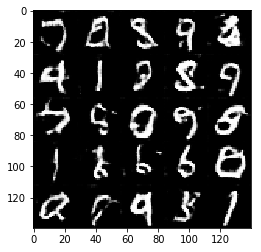

Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 0.9256 Batch: 1310.0000
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.9974 Batch: 1320.0000
Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 1.0129 Batch: 1330.0000
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 1.2299 Batch: 1340.0000
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 1.0504 Batch: 1350.0000
Epoch 1/2... Discriminator Loss: 1.4337... Generator Loss: 0.5770 Batch: 1360.0000
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.8205 Batch: 1370.0000
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 1.1445 Batch: 1380.0000
Epoch 1/2... Discriminator Loss: 0.7448... Generator Loss: 2.0219 Batch: 1390.0000
Epoch 1/2... Discriminator Loss: 1.6832... Generator Loss: 0.4355 Batch: 1400.0000


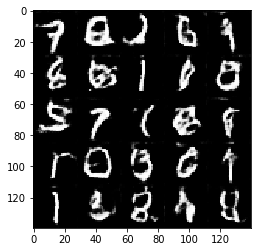

Epoch 1/2... Discriminator Loss: 0.9531... Generator Loss: 1.7732 Batch: 1410.0000
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.8278 Batch: 1420.0000
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 1.6779 Batch: 1430.0000
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.6632 Batch: 1440.0000
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.7377 Batch: 1450.0000
Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 1.7023 Batch: 1460.0000
Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 0.5018 Batch: 1470.0000
Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 0.9049 Batch: 1480.0000
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.7417 Batch: 1490.0000
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 0.6880 Batch: 1500.0000


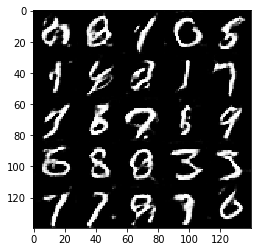

Epoch 1/2... Discriminator Loss: 1.6788... Generator Loss: 0.4557 Batch: 1510.0000
Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 1.7268 Batch: 1520.0000
Epoch 1/2... Discriminator Loss: 2.0681... Generator Loss: 0.3064 Batch: 1530.0000
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 1.4994 Batch: 1540.0000
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 1.2605 Batch: 1550.0000
Epoch 1/2... Discriminator Loss: 1.6517... Generator Loss: 0.4332 Batch: 1560.0000
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.8276 Batch: 1570.0000
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 1.8733 Batch: 1580.0000
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 0.8380 Batch: 1590.0000
Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 0.9159 Batch: 1600.0000


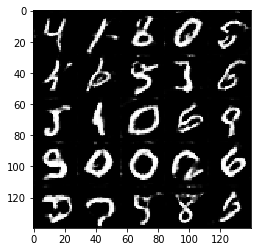

Epoch 1/2... Discriminator Loss: 1.4945... Generator Loss: 0.5844 Batch: 1610.0000
Epoch 1/2... Discriminator Loss: 1.6738... Generator Loss: 0.4241 Batch: 1620.0000
Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 1.4190 Batch: 1630.0000
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 1.1714 Batch: 1640.0000
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.2029 Batch: 1650.0000
Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 1.3900 Batch: 1660.0000
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.9176 Batch: 1670.0000
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 1.0864 Batch: 1680.0000
Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 1.0761 Batch: 1690.0000
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 1.2376 Batch: 1700.0000


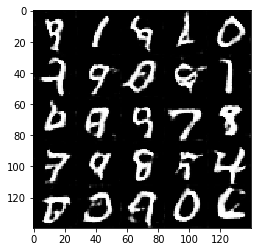

Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 1.4346 Batch: 1710.0000
Epoch 1/2... Discriminator Loss: 1.5522... Generator Loss: 0.6410 Batch: 1720.0000
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.7755 Batch: 1730.0000
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 1.4266 Batch: 1740.0000
Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.1290 Batch: 1750.0000
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 1.2093 Batch: 1760.0000
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 0.8276 Batch: 1770.0000
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 1.0175 Batch: 1780.0000
Epoch 1/2... Discriminator Loss: 0.9780... Generator Loss: 0.9961 Batch: 1790.0000
Epoch 1/2... Discriminator Loss: 0.5899... Generator Loss: 2.4929 Batch: 1800.0000


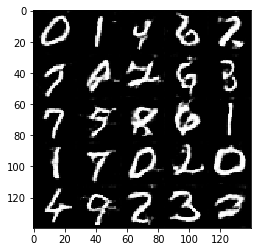

Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 1.8162 Batch: 1810.0000
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 0.9997 Batch: 1820.0000
Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 3.1561 Batch: 1830.0000
Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 0.9947 Batch: 1840.0000
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 2.1118 Batch: 1850.0000
Epoch 1/2... Discriminator Loss: 1.5473... Generator Loss: 0.4874 Batch: 1860.0000
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 1.1629 Batch: 1870.0000
Epoch 2/2... Discriminator Loss: 0.8423... Generator Loss: 1.1424 Batch: 1880.0000
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 2.1462 Batch: 1890.0000
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 1.0438 Batch: 1900.0000


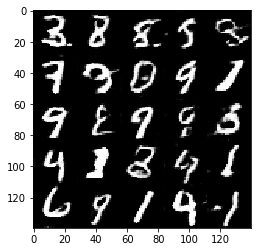

Epoch 2/2... Discriminator Loss: 1.0392... Generator Loss: 0.9102 Batch: 1910.0000
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 0.8354 Batch: 1920.0000
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.1237 Batch: 1930.0000
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 1.7846 Batch: 1940.0000
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.7752 Batch: 1950.0000
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.8351 Batch: 1960.0000
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.7171 Batch: 1970.0000
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.6300 Batch: 1980.0000
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 1.2100 Batch: 1990.0000
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.1601 Batch: 2000.0000


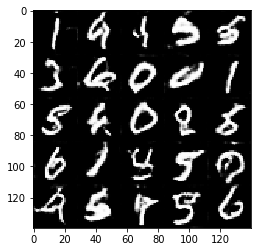

Epoch 2/2... Discriminator Loss: 0.8878... Generator Loss: 1.3490 Batch: 2010.0000
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.2292 Batch: 2020.0000
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.6194 Batch: 2030.0000
Epoch 2/2... Discriminator Loss: 0.6468... Generator Loss: 1.8290 Batch: 2040.0000
Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 1.4148 Batch: 2050.0000
Epoch 2/2... Discriminator Loss: 0.7972... Generator Loss: 1.9704 Batch: 2060.0000
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.5635 Batch: 2070.0000
Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 0.8456 Batch: 2080.0000
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.7196 Batch: 2090.0000
Epoch 2/2... Discriminator Loss: 0.7681... Generator Loss: 2.0574 Batch: 2100.0000


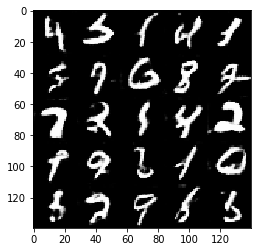

Epoch 2/2... Discriminator Loss: 1.6096... Generator Loss: 0.4839 Batch: 2110.0000
Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 1.1682 Batch: 2120.0000
Epoch 2/2... Discriminator Loss: 0.7141... Generator Loss: 1.3534 Batch: 2130.0000
Epoch 2/2... Discriminator Loss: 0.6546... Generator Loss: 2.2582 Batch: 2140.0000
Epoch 2/2... Discriminator Loss: 1.5771... Generator Loss: 0.6307 Batch: 2150.0000
Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 1.0703 Batch: 2160.0000
Epoch 2/2... Discriminator Loss: 1.1846... Generator Loss: 0.7873 Batch: 2170.0000
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 2.2276 Batch: 2180.0000
Epoch 2/2... Discriminator Loss: 0.5828... Generator Loss: 2.0630 Batch: 2190.0000
Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 2.0852 Batch: 2200.0000


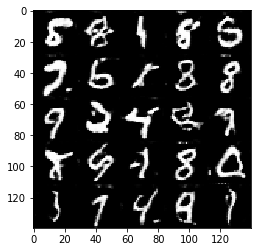

Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 1.3547 Batch: 2210.0000
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 1.9440 Batch: 2220.0000
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.6430 Batch: 2230.0000
Epoch 2/2... Discriminator Loss: 0.7495... Generator Loss: 1.4912 Batch: 2240.0000
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.2579 Batch: 2250.0000
Epoch 2/2... Discriminator Loss: 0.6686... Generator Loss: 1.9116 Batch: 2260.0000
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 1.1570 Batch: 2270.0000
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.2039 Batch: 2280.0000
Epoch 2/2... Discriminator Loss: 1.6137... Generator Loss: 0.4651 Batch: 2290.0000
Epoch 2/2... Discriminator Loss: 0.5728... Generator Loss: 2.0983 Batch: 2300.0000


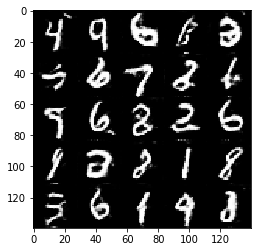

Epoch 2/2... Discriminator Loss: 1.5024... Generator Loss: 3.2294 Batch: 2310.0000
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.2865 Batch: 2320.0000
Epoch 2/2... Discriminator Loss: 1.0938... Generator Loss: 0.9366 Batch: 2330.0000
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.1041 Batch: 2340.0000
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 2.1433 Batch: 2350.0000
Epoch 2/2... Discriminator Loss: 0.8669... Generator Loss: 1.2936 Batch: 2360.0000
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 0.5875 Batch: 2370.0000
Epoch 2/2... Discriminator Loss: 0.8060... Generator Loss: 1.4375 Batch: 2380.0000
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.8448 Batch: 2390.0000
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 0.9616 Batch: 2400.0000


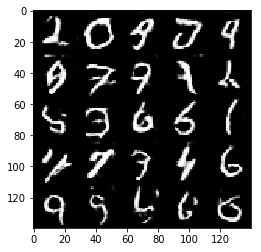

Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 1.3681 Batch: 2410.0000
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.0469 Batch: 2420.0000
Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 1.8058 Batch: 2430.0000
Epoch 2/2... Discriminator Loss: 1.1319... Generator Loss: 0.9035 Batch: 2440.0000
Epoch 2/2... Discriminator Loss: 0.7753... Generator Loss: 1.4662 Batch: 2450.0000
Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 1.1953 Batch: 2460.0000
Epoch 2/2... Discriminator Loss: 1.5872... Generator Loss: 0.5115 Batch: 2470.0000
Epoch 2/2... Discriminator Loss: 0.6589... Generator Loss: 1.6513 Batch: 2480.0000
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.8654 Batch: 2490.0000
Epoch 2/2... Discriminator Loss: 1.4617... Generator Loss: 0.5901 Batch: 2500.0000


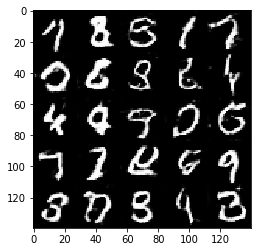

Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 1.2866 Batch: 2510.0000
Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 1.3358 Batch: 2520.0000
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 1.2745 Batch: 2530.0000
Epoch 2/2... Discriminator Loss: 1.4250... Generator Loss: 0.5491 Batch: 2540.0000
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 0.7918 Batch: 2550.0000
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.6922 Batch: 2560.0000
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 2.6887 Batch: 2570.0000
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 2.8479 Batch: 2580.0000
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 1.5979 Batch: 2590.0000
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.9800 Batch: 2600.0000


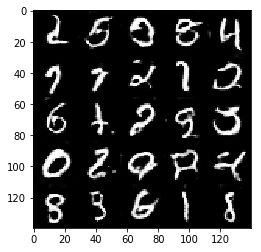

Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 1.3678 Batch: 2610.0000
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 1.4240 Batch: 2620.0000
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 1.3858 Batch: 2630.0000
Epoch 2/2... Discriminator Loss: 1.4862... Generator Loss: 0.5921 Batch: 2640.0000
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 1.7813 Batch: 2650.0000
Epoch 2/2... Discriminator Loss: 2.0277... Generator Loss: 4.8011 Batch: 2660.0000
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 1.0571 Batch: 2670.0000
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.8844 Batch: 2680.0000
Epoch 2/2... Discriminator Loss: 0.8807... Generator Loss: 1.2186 Batch: 2690.0000
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.7551 Batch: 2700.0000


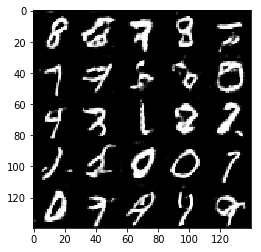

Epoch 2/2... Discriminator Loss: 0.5275... Generator Loss: 2.1182 Batch: 2710.0000
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 0.9796 Batch: 2720.0000
Epoch 2/2... Discriminator Loss: 1.2374... Generator Loss: 0.7026 Batch: 2730.0000
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 2.3047 Batch: 2740.0000
Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 1.9708 Batch: 2750.0000
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.6935 Batch: 2760.0000
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 1.3817 Batch: 2770.0000
Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 2.6514 Batch: 2780.0000
Epoch 2/2... Discriminator Loss: 1.2790... Generator Loss: 0.6270 Batch: 2790.0000
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 0.7550 Batch: 2800.0000


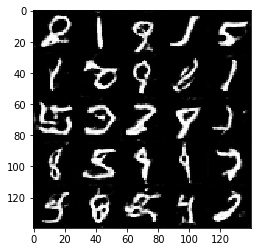

Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 2.7436 Batch: 2810.0000
Epoch 2/2... Discriminator Loss: 1.6257... Generator Loss: 0.5616 Batch: 2820.0000
Epoch 2/2... Discriminator Loss: 0.8680... Generator Loss: 1.0375 Batch: 2830.0000
Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 1.1599 Batch: 2840.0000
Epoch 2/2... Discriminator Loss: 1.1524... Generator Loss: 1.0973 Batch: 2850.0000
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 0.9070 Batch: 2860.0000
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 1.0201 Batch: 2870.0000
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 3.0302 Batch: 2880.0000
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 1.0422 Batch: 2890.0000
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 3.0008 Batch: 2900.0000


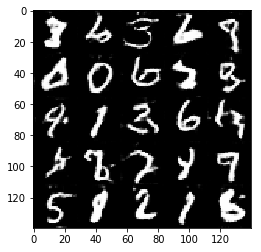

Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 1.4524 Batch: 2910.0000
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 1.1910 Batch: 2920.0000
Epoch 2/2... Discriminator Loss: 0.7483... Generator Loss: 1.5991 Batch: 2930.0000
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 1.3530 Batch: 2940.0000
Epoch 2/2... Discriminator Loss: 0.6788... Generator Loss: 2.0203 Batch: 2950.0000
Epoch 2/2... Discriminator Loss: 0.7619... Generator Loss: 1.6951 Batch: 2960.0000
Epoch 2/2... Discriminator Loss: 0.8435... Generator Loss: 1.2262 Batch: 2970.0000
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 1.0614 Batch: 2980.0000
Epoch 2/2... Discriminator Loss: 2.1165... Generator Loss: 0.3454 Batch: 2990.0000
Epoch 2/2... Discriminator Loss: 0.8121... Generator Loss: 2.4406 Batch: 3000.0000


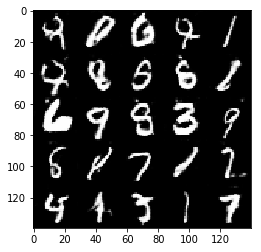

Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.6835 Batch: 3010.0000
Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 2.1518 Batch: 3020.0000
Epoch 2/2... Discriminator Loss: 0.8637... Generator Loss: 1.3662 Batch: 3030.0000
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.6518 Batch: 3040.0000
Epoch 2/2... Discriminator Loss: 0.4641... Generator Loss: 2.6815 Batch: 3050.0000
Epoch 2/2... Discriminator Loss: 1.0867... Generator Loss: 2.3268 Batch: 3060.0000
Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 1.0626 Batch: 3070.0000
Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 1.8069 Batch: 3080.0000
Epoch 2/2... Discriminator Loss: 1.6837... Generator Loss: 0.4255 Batch: 3090.0000
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 1.1475 Batch: 3100.0000


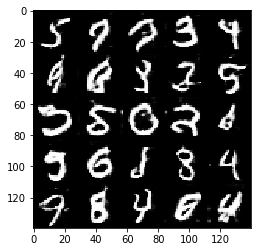

Epoch 2/2... Discriminator Loss: 0.7759... Generator Loss: 1.6513 Batch: 3110.0000
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.7806 Batch: 3120.0000
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.5940 Batch: 3130.0000
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.3792 Batch: 3140.0000
Epoch 2/2... Discriminator Loss: 1.0137... Generator Loss: 1.1789 Batch: 3150.0000
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.2345 Batch: 3160.0000
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 1.1918 Batch: 3170.0000
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.6278 Batch: 3180.0000
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.1104 Batch: 3190.0000
Epoch 2/2... Discriminator Loss: 0.7536... Generator Loss: 1.7113 Batch: 3200.0000


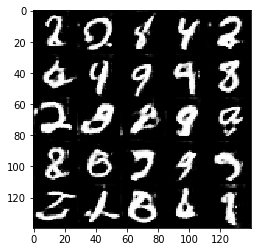

Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.5590 Batch: 3210.0000
Epoch 2/2... Discriminator Loss: 1.2134... Generator Loss: 0.7336 Batch: 3220.0000
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 2.5107 Batch: 3230.0000
Epoch 2/2... Discriminator Loss: 0.7056... Generator Loss: 2.6247 Batch: 3240.0000
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.4428 Batch: 3250.0000
Epoch 2/2... Discriminator Loss: 1.5605... Generator Loss: 0.6111 Batch: 3260.0000
Epoch 2/2... Discriminator Loss: 1.8641... Generator Loss: 0.3999 Batch: 3270.0000
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.9763 Batch: 3280.0000
Epoch 2/2... Discriminator Loss: 1.3114... Generator Loss: 0.7020 Batch: 3290.0000
Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 2.0930 Batch: 3300.0000


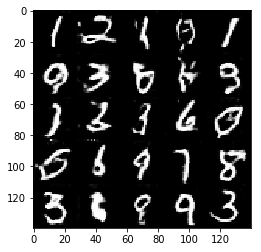

Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.5926 Batch: 3310.0000
Epoch 2/2... Discriminator Loss: 0.5200... Generator Loss: 2.1786 Batch: 3320.0000
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 1.7328 Batch: 3330.0000
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 1.3539 Batch: 3340.0000
Epoch 2/2... Discriminator Loss: 1.5247... Generator Loss: 0.5709 Batch: 3350.0000
Epoch 2/2... Discriminator Loss: 0.4699... Generator Loss: 2.7426 Batch: 3360.0000
Epoch 2/2... Discriminator Loss: 0.6186... Generator Loss: 1.6980 Batch: 3370.0000
Epoch 2/2... Discriminator Loss: 0.8083... Generator Loss: 1.1835 Batch: 3380.0000
Epoch 2/2... Discriminator Loss: 0.8950... Generator Loss: 3.4620 Batch: 3390.0000
Epoch 2/2... Discriminator Loss: 0.8904... Generator Loss: 1.0819 Batch: 3400.0000


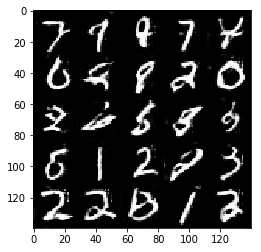

Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.6057 Batch: 3410.0000
Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 1.5049 Batch: 3420.0000
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 0.7542 Batch: 3430.0000
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 1.1064 Batch: 3440.0000
Epoch 2/2... Discriminator Loss: 0.6488... Generator Loss: 1.7142 Batch: 3450.0000
Epoch 2/2... Discriminator Loss: 0.6965... Generator Loss: 1.5882 Batch: 3460.0000
Epoch 2/2... Discriminator Loss: 0.6005... Generator Loss: 1.8214 Batch: 3470.0000
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 1.9714 Batch: 3480.0000
Epoch 2/2... Discriminator Loss: 0.9032... Generator Loss: 1.3630 Batch: 3490.0000
Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 2.1062 Batch: 3500.0000


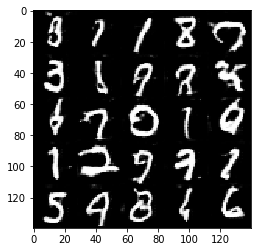

Epoch 2/2... Discriminator Loss: 1.8951... Generator Loss: 0.4659 Batch: 3510.0000
Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 2.7012 Batch: 3520.0000
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.6490 Batch: 3530.0000
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 1.0365 Batch: 3540.0000
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.6798 Batch: 3550.0000
Epoch 2/2... Discriminator Loss: 0.6823... Generator Loss: 1.7518 Batch: 3560.0000
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.1943 Batch: 3570.0000
Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 1.0508 Batch: 3580.0000
Epoch 2/2... Discriminator Loss: 2.1872... Generator Loss: 0.3005 Batch: 3590.0000
Epoch 2/2... Discriminator Loss: 0.8980... Generator Loss: 1.2744 Batch: 3600.0000


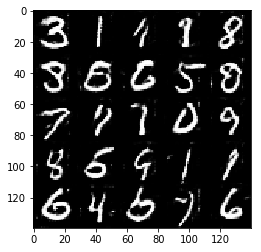

Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.6115 Batch: 3610.0000
Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 1.5000 Batch: 3620.0000
Epoch 2/2... Discriminator Loss: 0.6681... Generator Loss: 1.6734 Batch: 3630.0000
Epoch 2/2... Discriminator Loss: 1.5161... Generator Loss: 0.5121 Batch: 3640.0000
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 1.1684 Batch: 3650.0000
Epoch 2/2... Discriminator Loss: 1.6640... Generator Loss: 0.4738 Batch: 3660.0000
Epoch 2/2... Discriminator Loss: 0.7635... Generator Loss: 1.3704 Batch: 3670.0000
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.8159 Batch: 3680.0000
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.3923 Batch: 3690.0000
Epoch 2/2... Discriminator Loss: 0.8445... Generator Loss: 1.2426 Batch: 3700.0000


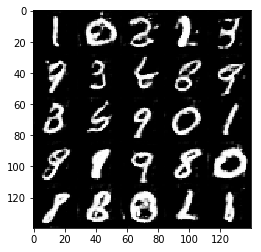

Epoch 2/2... Discriminator Loss: 0.6178... Generator Loss: 2.3020 Batch: 3710.0000
Epoch 2/2... Discriminator Loss: 0.7426... Generator Loss: 1.3812 Batch: 3720.0000
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 0.8700 Batch: 3730.0000
Epoch 2/2... Discriminator Loss: 0.6572... Generator Loss: 1.8715 Batch: 3740.0000
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 1.0072 Batch: 3750.0000


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.9949 Batch: 10.0000
Epoch 1/1... Discriminator Loss: 3.5996... Generator Loss: 0.0799 Batch: 20.0000
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 1.6854 Batch: 30.0000
Epoch 1/1... Discriminator Loss: 1.8317... Generator Loss: 0.4514 Batch: 40.0000
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 1.0606 Batch: 50.0000
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 2.5006 Batch: 60.0000
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 2.3921 Batch: 70.0000
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.5680 Batch: 80.0000
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.1176 Batch: 90.0000
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.4502 Batch: 100.0000


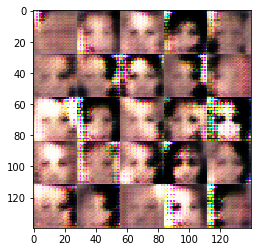

Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.5927 Batch: 110.0000
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7447 Batch: 120.0000
Epoch 1/1... Discriminator Loss: 1.6249... Generator Loss: 1.6203 Batch: 130.0000
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.9881 Batch: 140.0000
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 1.1639 Batch: 150.0000
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.8426 Batch: 160.0000
Epoch 1/1... Discriminator Loss: 1.6022... Generator Loss: 0.6348 Batch: 170.0000
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.7939 Batch: 180.0000
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8860 Batch: 190.0000
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.0590 Batch: 200.0000


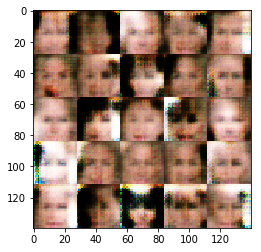

Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 1.1402 Batch: 210.0000
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.8151 Batch: 220.0000
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6870 Batch: 230.0000
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 1.2958 Batch: 240.0000
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.7249 Batch: 250.0000
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7368 Batch: 260.0000
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.9098 Batch: 270.0000
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6347 Batch: 280.0000
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.8350 Batch: 290.0000
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.6793 Batch: 300.0000


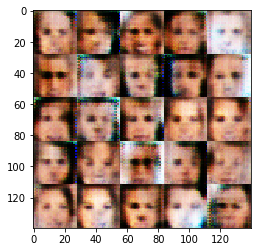

Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.9941 Batch: 310.0000
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8797 Batch: 320.0000
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8345 Batch: 330.0000
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 1.3355 Batch: 340.0000
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8638 Batch: 350.0000
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8911 Batch: 360.0000
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.1036 Batch: 370.0000
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.8414 Batch: 380.0000
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 1.1155 Batch: 390.0000
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7215 Batch: 400.0000


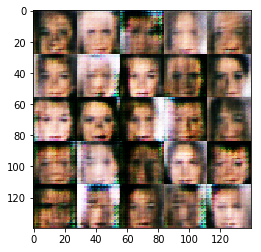

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6356 Batch: 410.0000
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 1.0091 Batch: 420.0000
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6320 Batch: 430.0000
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.1905 Batch: 440.0000
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7294 Batch: 450.0000
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.9015 Batch: 460.0000
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.0261 Batch: 470.0000
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 1.1082 Batch: 480.0000
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7771 Batch: 490.0000
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 1.3890 Batch: 500.0000


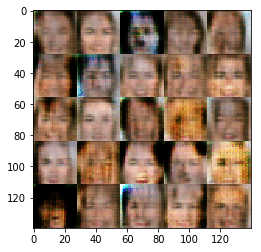

Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.6724 Batch: 510.0000
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.9785 Batch: 520.0000
Epoch 1/1... Discriminator Loss: 1.7572... Generator Loss: 1.5364 Batch: 530.0000
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.5169 Batch: 540.0000
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.7168 Batch: 550.0000
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 1.1037 Batch: 560.0000
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7377 Batch: 570.0000
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9225 Batch: 580.0000
Epoch 1/1... Discriminator Loss: 1.6432... Generator Loss: 0.5331 Batch: 590.0000
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 1.0454 Batch: 600.0000


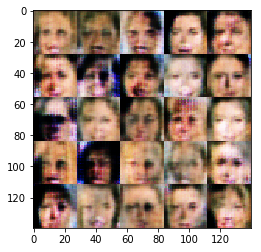

Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.8418 Batch: 610.0000
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.0220 Batch: 620.0000
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.9046 Batch: 630.0000
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 1.2859 Batch: 640.0000
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7281 Batch: 650.0000
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.9227 Batch: 660.0000
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5143 Batch: 670.0000
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.6875 Batch: 680.0000
Epoch 1/1... Discriminator Loss: 1.7629... Generator Loss: 0.3217 Batch: 690.0000
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.6974 Batch: 700.0000


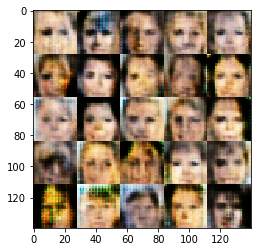

Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 1.4965 Batch: 710.0000
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7697 Batch: 720.0000
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.9172 Batch: 730.0000
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6561 Batch: 740.0000
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.9109 Batch: 750.0000
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7555 Batch: 760.0000
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 1.0829 Batch: 770.0000
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7560 Batch: 780.0000
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.5968 Batch: 790.0000
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7475 Batch: 800.0000


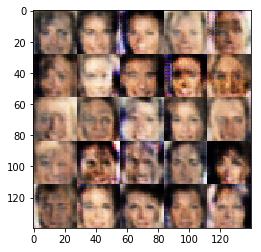

Epoch 1/1... Discriminator Loss: 1.6133... Generator Loss: 1.4083 Batch: 810.0000
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6719 Batch: 820.0000
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.8747 Batch: 830.0000
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 1.0048 Batch: 840.0000
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.7773 Batch: 850.0000
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8727 Batch: 860.0000
Epoch 1/1... Discriminator Loss: 1.7275... Generator Loss: 0.8317 Batch: 870.0000
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6892 Batch: 880.0000
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8359 Batch: 890.0000
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7776 Batch: 900.0000


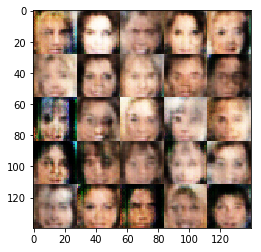

Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6487 Batch: 910.0000
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.9152 Batch: 920.0000
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8567 Batch: 930.0000
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6188 Batch: 940.0000
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.9803 Batch: 950.0000
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.8197 Batch: 960.0000
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.9779 Batch: 970.0000
Epoch 1/1... Discriminator Loss: 1.6358... Generator Loss: 0.6525 Batch: 980.0000
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 1.1136 Batch: 990.0000
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7806 Batch: 1000.0000


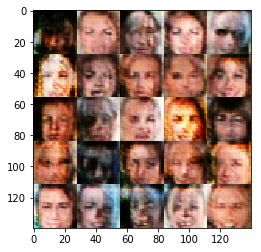

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 1.0328 Batch: 1010.0000
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8276 Batch: 1020.0000
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7577 Batch: 1030.0000
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.8451 Batch: 1040.0000
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.9032 Batch: 1050.0000
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.9235 Batch: 1060.0000
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.8478 Batch: 1070.0000
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 1.0309 Batch: 1080.0000
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6938 Batch: 1090.0000
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.8702 Batch: 1100.0000


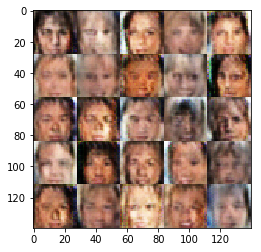

Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6628 Batch: 1110.0000
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8382 Batch: 1120.0000
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9681 Batch: 1130.0000
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.9512 Batch: 1140.0000
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7590 Batch: 1150.0000
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.6040 Batch: 1160.0000
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7544 Batch: 1170.0000
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.8546 Batch: 1180.0000
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7052 Batch: 1190.0000
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7710 Batch: 1200.0000


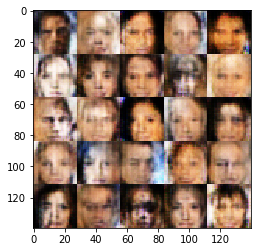

Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8210 Batch: 1210.0000
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.9278 Batch: 1220.0000
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5789 Batch: 1230.0000
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6695 Batch: 1240.0000
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7799 Batch: 1250.0000
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 1.0357 Batch: 1260.0000
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8070 Batch: 1270.0000
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.6710 Batch: 1280.0000
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.8542 Batch: 1290.0000
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 1.0499 Batch: 1300.0000


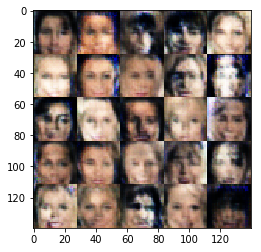

Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.8141 Batch: 1310.0000
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7542 Batch: 1320.0000
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.5374 Batch: 1330.0000
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.9134 Batch: 1340.0000
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.9992 Batch: 1350.0000
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.9037 Batch: 1360.0000
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7202 Batch: 1370.0000
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7729 Batch: 1380.0000
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.7785 Batch: 1390.0000
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8647 Batch: 1400.0000


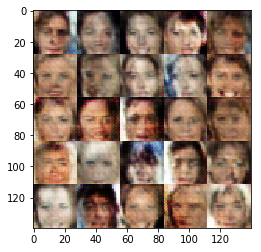

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8146 Batch: 1410.0000
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8416 Batch: 1420.0000
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7983 Batch: 1430.0000
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 1.1350 Batch: 1440.0000
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.9761 Batch: 1450.0000
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7786 Batch: 1460.0000
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7974 Batch: 1470.0000
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8671 Batch: 1480.0000
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 1.0014 Batch: 1490.0000
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.9060 Batch: 1500.0000


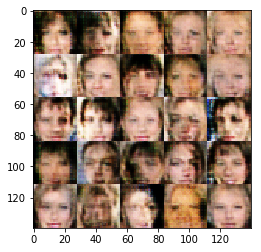

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.9087 Batch: 1510.0000
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.7352 Batch: 1520.0000
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.9320 Batch: 1530.0000
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.9142 Batch: 1540.0000
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7765 Batch: 1550.0000
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.7324 Batch: 1560.0000
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.7248 Batch: 1570.0000
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.8888 Batch: 1580.0000
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.9822 Batch: 1590.0000
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8024 Batch: 1600.0000


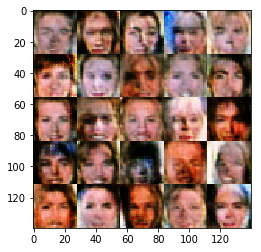

Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 1.1287 Batch: 1610.0000
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7896 Batch: 1620.0000
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.8028 Batch: 1630.0000
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.9151 Batch: 1640.0000
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6365 Batch: 1650.0000
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8584 Batch: 1660.0000
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.8760 Batch: 1670.0000
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6446 Batch: 1680.0000
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8637 Batch: 1690.0000
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8047 Batch: 1700.0000


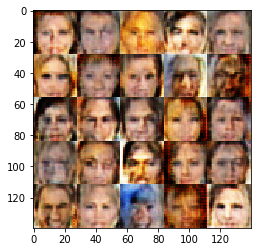

Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 1.0670 Batch: 1710.0000
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.8459 Batch: 1720.0000
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7789 Batch: 1730.0000
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7990 Batch: 1740.0000
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7191 Batch: 1750.0000
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6600 Batch: 1760.0000
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7423 Batch: 1770.0000
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8541 Batch: 1780.0000
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8005 Batch: 1790.0000
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7740 Batch: 1800.0000


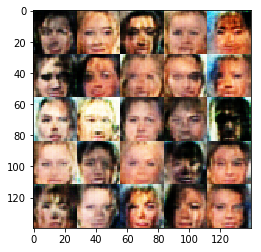

Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.7476 Batch: 1810.0000
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.9189 Batch: 1820.0000
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8112 Batch: 1830.0000
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7730 Batch: 1840.0000
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6295 Batch: 1850.0000
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8367 Batch: 1860.0000
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6979 Batch: 1870.0000
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.6513 Batch: 1880.0000
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 1.0325 Batch: 1890.0000
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.8178 Batch: 1900.0000


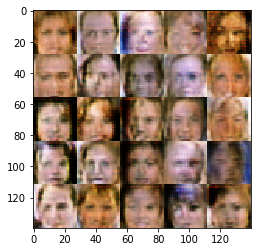

Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6817 Batch: 1910.0000
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.5919 Batch: 1920.0000
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 1.1769 Batch: 1930.0000
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7270 Batch: 1940.0000
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.5690 Batch: 1950.0000
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7914 Batch: 1960.0000
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6906 Batch: 1970.0000
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 1.1536 Batch: 1980.0000
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.9022 Batch: 1990.0000
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.7199 Batch: 2000.0000


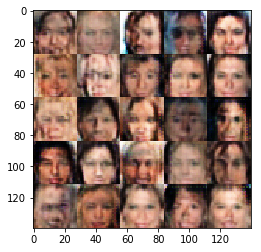

Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.8506 Batch: 2010.0000
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 1.0295 Batch: 2020.0000
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7024 Batch: 2030.0000
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.7158 Batch: 2040.0000
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.9667 Batch: 2050.0000
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.9700 Batch: 2060.0000
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7664 Batch: 2070.0000
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.8805 Batch: 2080.0000
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7493 Batch: 2090.0000
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.7614 Batch: 2100.0000


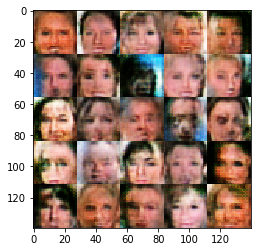

Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7437 Batch: 2110.0000
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7284 Batch: 2120.0000
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.7786 Batch: 2130.0000
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7297 Batch: 2140.0000
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7629 Batch: 2150.0000
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.8718 Batch: 2160.0000
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8435 Batch: 2170.0000
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7400 Batch: 2180.0000
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.9418 Batch: 2190.0000
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.9205 Batch: 2200.0000


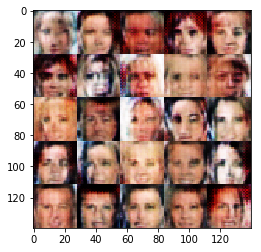

Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7565 Batch: 2210.0000
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8179 Batch: 2220.0000
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7950 Batch: 2230.0000
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6884 Batch: 2240.0000
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.9003 Batch: 2250.0000
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8465 Batch: 2260.0000
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.5848 Batch: 2270.0000
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.9611 Batch: 2280.0000
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7558 Batch: 2290.0000
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 1.0211 Batch: 2300.0000


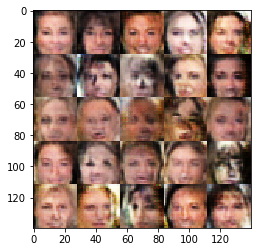

Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.9031 Batch: 2310.0000
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7296 Batch: 2320.0000
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8791 Batch: 2330.0000
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8121 Batch: 2340.0000
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 1.2216 Batch: 2350.0000
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.9044 Batch: 2360.0000
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 1.0771 Batch: 2370.0000
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.5883 Batch: 2380.0000
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.9070 Batch: 2390.0000
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.9718 Batch: 2400.0000


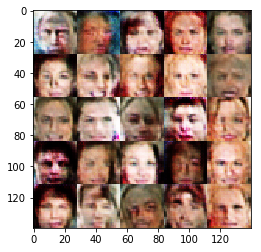

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.9757 Batch: 2410.0000
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6928 Batch: 2420.0000
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8142 Batch: 2430.0000
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8814 Batch: 2440.0000
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8587 Batch: 2450.0000
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.9736 Batch: 2460.0000
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 1.0004 Batch: 2470.0000
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8891 Batch: 2480.0000
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7996 Batch: 2490.0000
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.8181 Batch: 2500.0000


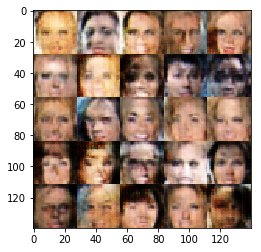

Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7114 Batch: 2510.0000
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8971 Batch: 2520.0000
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.8710 Batch: 2530.0000
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8780 Batch: 2540.0000
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7962 Batch: 2550.0000
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6941 Batch: 2560.0000
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.9272 Batch: 2570.0000
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8069 Batch: 2580.0000
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8167 Batch: 2590.0000
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8715 Batch: 2600.0000


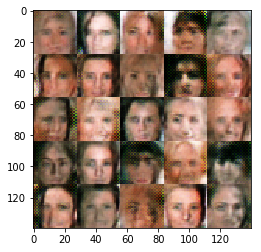

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8116 Batch: 2610.0000
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8706 Batch: 2620.0000
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7277 Batch: 2630.0000
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8464 Batch: 2640.0000
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7641 Batch: 2650.0000
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 1.1471 Batch: 2660.0000
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7495 Batch: 2670.0000
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.8437 Batch: 2680.0000
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8015 Batch: 2690.0000
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7787 Batch: 2700.0000


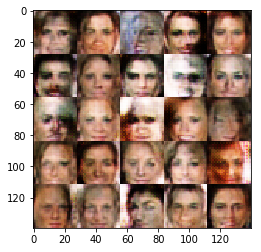

Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7296 Batch: 2710.0000
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.5385 Batch: 2720.0000
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7673 Batch: 2730.0000
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7526 Batch: 2740.0000
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.6829 Batch: 2750.0000
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.8201 Batch: 2760.0000
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7368 Batch: 2770.0000
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 1.1083 Batch: 2780.0000
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8422 Batch: 2790.0000
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8057 Batch: 2800.0000


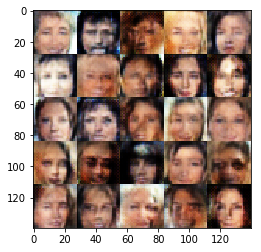

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.7326 Batch: 2810.0000
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8827 Batch: 2820.0000
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8743 Batch: 2830.0000
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8370 Batch: 2840.0000
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8516 Batch: 2850.0000
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.9340 Batch: 2860.0000
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7868 Batch: 2870.0000
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.9915 Batch: 2880.0000
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8994 Batch: 2890.0000
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7285 Batch: 2900.0000


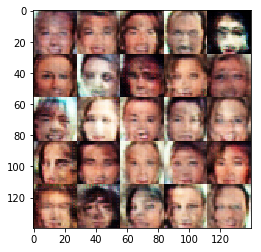

Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.8556 Batch: 2910.0000
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7429 Batch: 2920.0000
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6530 Batch: 2930.0000
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7406 Batch: 2940.0000
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.9011 Batch: 2950.0000
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8899 Batch: 2960.0000
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6497 Batch: 2970.0000
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6569 Batch: 2980.0000
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7342 Batch: 2990.0000
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.7978 Batch: 3000.0000


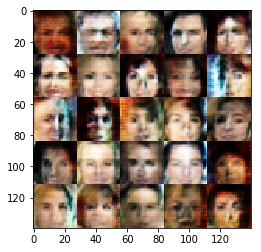

Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7777 Batch: 3010.0000
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.8408 Batch: 3020.0000
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.9787 Batch: 3030.0000
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7361 Batch: 3040.0000
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.9049 Batch: 3050.0000
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7683 Batch: 3060.0000
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8051 Batch: 3070.0000
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 1.0113 Batch: 3080.0000
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8479 Batch: 3090.0000
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7730 Batch: 3100.0000


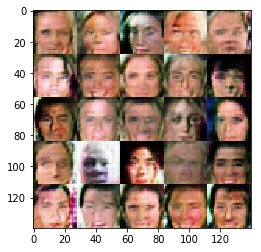

Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6882 Batch: 3110.0000
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.9013 Batch: 3120.0000
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8614 Batch: 3130.0000
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.8569 Batch: 3140.0000
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6762 Batch: 3150.0000
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.8761 Batch: 3160.0000


In [76]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.